In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt

In [4]:
import sys

sys.path.extend(
    [
        'flock',
        'flock-web',
        'flock-conf',
        'src/poultry',
    ]
)

In [5]:
import os
from urllib.parse import urlparse, parse_qs

import sqlalchemy as sa
from sqlalchemy.orm import sessionmaker

import pandas as pd

from flock import model
from flock_web import model as fw_model

import graph_tool as gt
import graph_tool.draw
import graph_tool.collection

/home/dnm11/miniconda3/lib/python3.6/site-packages/graph_tool/draw/cairo_draw.py:1480: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


In [6]:
engine = sa.create_engine('postgresql://dnm11:{}@129.6.101.99:15432/twitter'.format(os.environ['DB_PASS']), echo=False)
conn = engine.connect()
model.metadata.bind = engine

Session = sessionmaker(bind=engine)
session = Session()

In [18]:
user_actions = pd.DataFrame(
    [
        (
            a.id, a.timestamp, a.url, a.headers['Referer'],
            a.request_args['q'][0],
            'on' in a.request_args.get('show_images', []),
            'pmi' in a.request_args.get('filter', []),
        )
        for a in (
            session
            .query(fw_model.UserAction)
            .filter(fw_model.UserAction.url != None)
            .filter(fw_model.UserAction.endpoint == 'collection.tweets')
            .filter(fw_model.UserAction.user_id == 9)
        )
    ],
    columns=('id', 'timestamp', 'url', 'referer', 'query', 'show_images', 'filter'),
).set_index('id', drop=False)

In [19]:
user_actions.head()

,id,timestamp,url,referer,query,show_images,filter
id,,,,,,,
10110,10110,2017-06-12 10:19:27.312384,http://129.6.101.99/c/2016-08-01/tweets?topic=...,http://129.6.101.99/c/2016-08-01/tweets?q=kids...,kids cycling,False,False
10161,10161,2017-06-12 10:38:54.457568,http://129.6.101.99/c/2016-08-01/tweets?q=foot...,http://129.6.101.99/c/2016-08-01/tweets?topic=...,football training camp,False,False
10095,10095,2017-06-12 10:14:24.376193,http://129.6.101.99/c/2016-08-01/tweets?q=kids...,http://129.6.101.99/c/2016-08-01/,kids cycling,False,False
10179,10179,2017-06-12 10:44:28.015633,http://129.6.101.99/c/2017-05-01/tweets?q=NFL+...,http://129.6.101.99/c/2016-08-01/tweets?q=NFL+...,NFL football training camp,False,False
10182,10182,2017-06-12 10:45:34.690517,http://129.6.101.99/c/2017-05-01/tweets?q=memo...,http://129.6.101.99/c/2017-05-01/tweets?q=NFL+...,memorial day celebrations,False,False


In [20]:
# user_actions['url'].drop_duplicates()

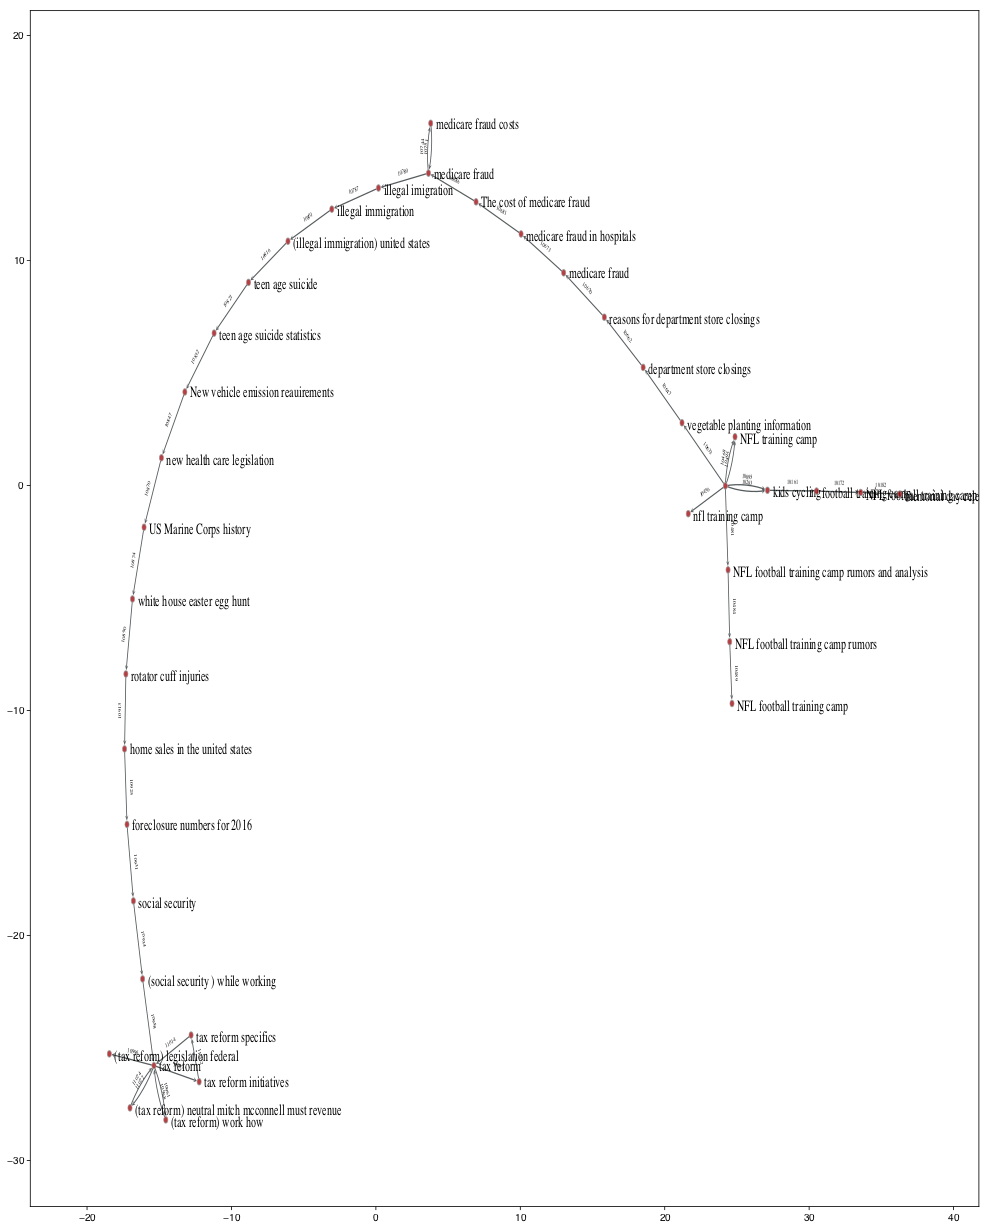

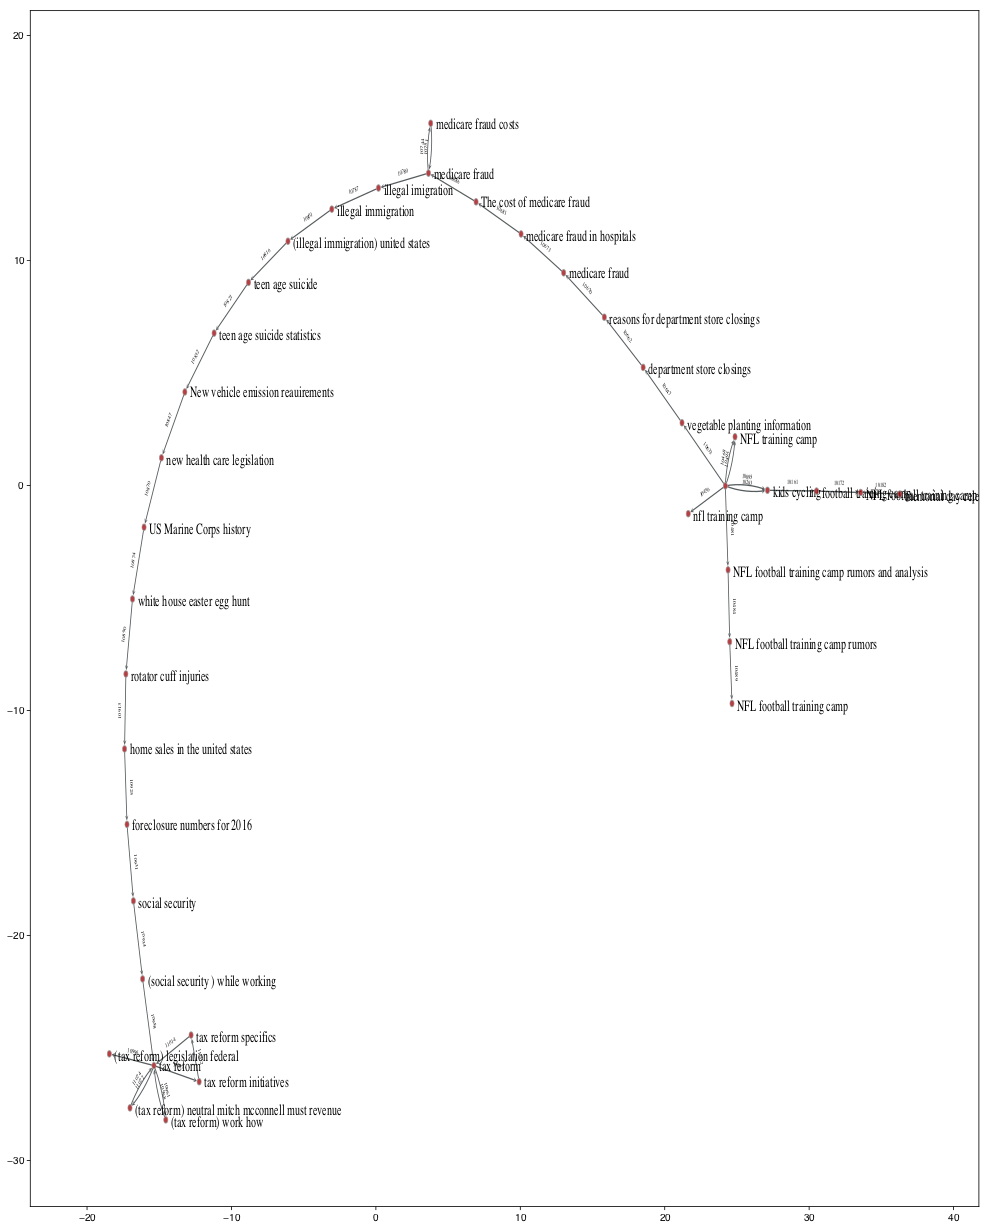

In [21]:
graph = gt.Graph()

vertex_label = graph.new_vertex_property('string')
edge_label = graph.new_edge_property('string')

vertices = {}
# for url in user_actions['url']:
#     v = graph.add_vertex()
#     vertex_label[v] = url
#     vertices[url] = v

for id_, url, referer, q in user_actions[['id', 'url', 'referer', 'query']].values:
    if id_ in [8652, 8846]:
        continue

    if not referer:
        continue

    referer = parse_qs(urlparse(referer).query).get('q', [''])[0]
    if referer not in vertices:
        v_ref = graph.add_vertex()
        vertices[referer] = v_ref
        vertex_label[v_ref] = referer
    else:
        v_ref = vertices[referer]

    url = parse_qs(urlparse(url).query).get('q', [''])[0]
    if url not in vertices:
        v_url = graph.add_vertex()
        vertex_label[v_url] = url
        vertices[url] = v_url
        vertex_label[v_url] = url
    else:
        v_url = vertices[url]
        
    if v_ref is not v_url:
        e = graph.add_edge(
            v_ref, v_url
        )

        edge_label[e] = str(id_)
    

plt.switch_backend('cairo')
fig = plt.figure()
fig.set_size_inches((8.5 * 2, 11 * 2))

pos = gt.draw.sfdp_layout(graph)
gt.draw.graph_draw(
    graph,
    pos=pos,
    mplfig=fig,
    vertex_text_position=0,
#     vertex_text=graph.vertex_index,
    vertex_text=vertex_label,
#     vertex_font_size=7,
    edge_text=edge_label,
    edge_font_size=5,
    output_size=(8.5 * 2, 11 * 2),
)

fig.savefig('/home/dnm11/Desktop/session.pdf')
fig